In [1]:
import zipfile
zip_path = '/content/breast+cancer+wisconsin+original.zip'  # Update path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [2]:
import pandas as pd

df = pd.read_csv('/content/dataset/breast-cancer-wisconsin.data', header=None)

# Assign column names (UCI doesn't include headers by default)
df.columns = ['ID', 'Clump Thickness', 'Uniformity of Cell Size',
              'Uniformity of Cell Shape', 'Marginal Adhesion',
              'Single Epithelial Cell Size', 'Bare Nuclei',
              'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']


In [3]:
df.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.isnull().sum()

,0
ID,0
Clump Thickness,0
Uniformity of Cell Size,0
Uniformity of Cell Shape,0
Marginal Adhesion,0
Single Epithelial Cell Size,0
Bare Nuclei,0
Bland Chromatin,0
Normal Nucleoli,0
Mitoses,0


In [5]:
# Replace missing values denoted as '?' and convert to numeric
df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei'], errors='coerce')
df.dropna(inplace=True)

# Drop ID
df.drop('ID', axis=1, inplace=True)

# Convert class: 2 (Benign), 4 (Malignant)
df['Class'] = df['Class'].map({2: 0, 4: 1})

## Data Visualization

- Class Distrubution

<ipython-input-6-7ac06a78290f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2')


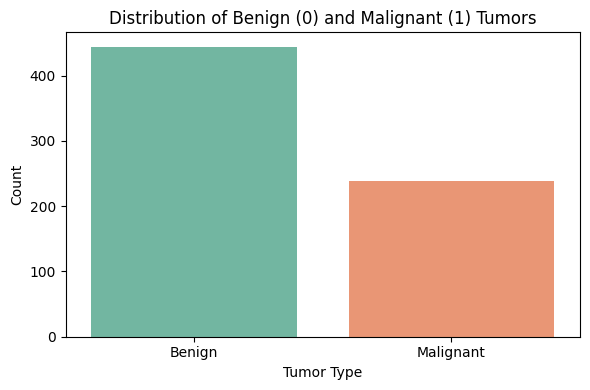

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Distribution of Benign (0) and Malignant (1) Tumors')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

- Feature Correlation Heatmap

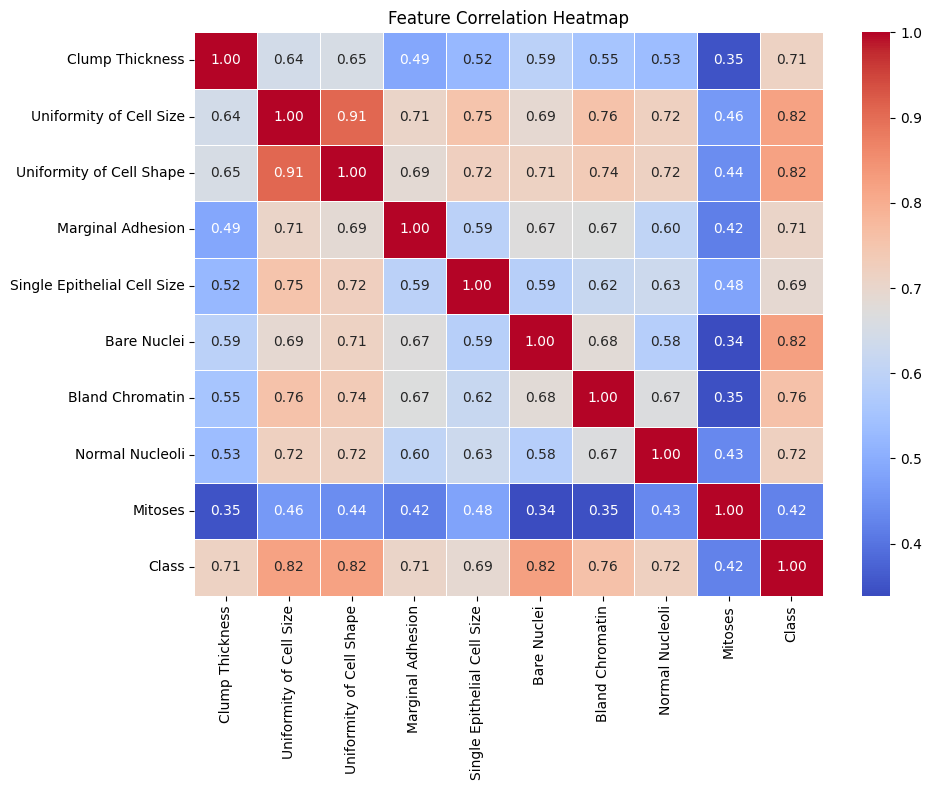

In [7]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

- Boxplot of Feature vs Tumor Class

<ipython-input-8-4ea441caca37>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Clump Thickness', data=df, palette='Set3')


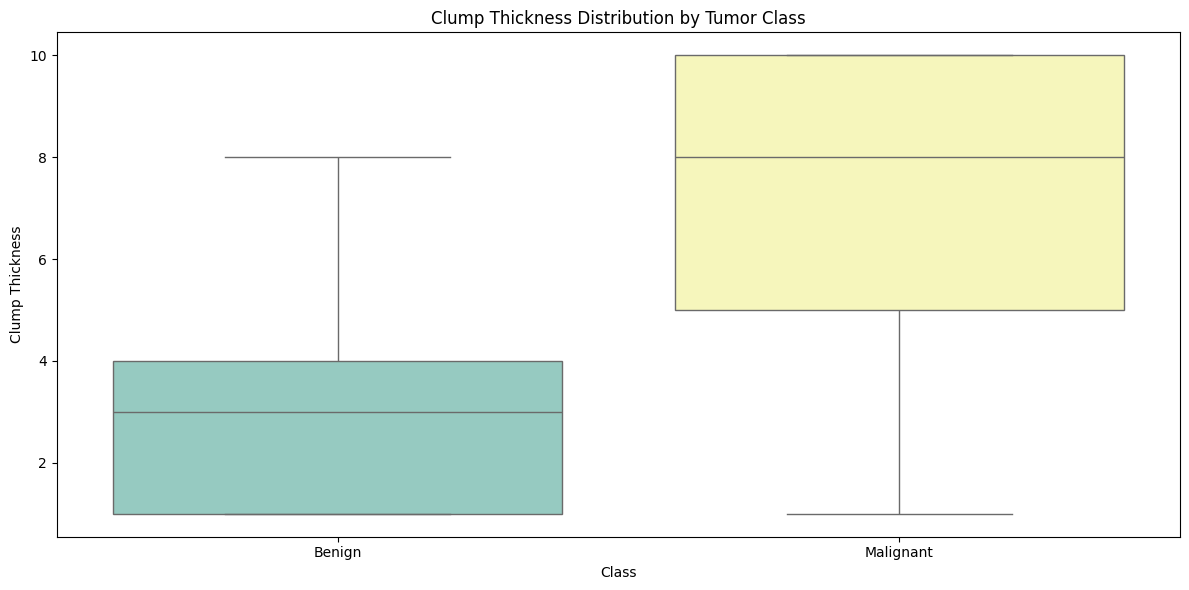

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Clump Thickness', data=df, palette='Set3')
plt.title('Clump Thickness Distribution by Tumor Class')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

# Building the Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Class', axis=1)
y = df['Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [10]:
#80% training data and 20% testing data
print("Training data: ",X_train.shape)
print("Testing data: ",X_test.shape)

Training data:  (546, 9)
Testing data:  (137, 9)


In [11]:
# Define ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
1                  SVM  0.963504   0.964912  0.948276  0.956522  0.997381
0  Logistic Regression  0.956204   0.981481  0.913793  0.946429  0.997818
2                  KNN  0.956204   0.981481  0.913793  0.946429  0.989742
4        Random Forest  0.948905   0.981132  0.896552  0.936937  0.995962
5              XGBoost  0.941606   0.962963  0.896552  0.928571  0.991052
3        Decision Tree  0.934307   0.962264  0.879310  0.918919  0.926997


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:24:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


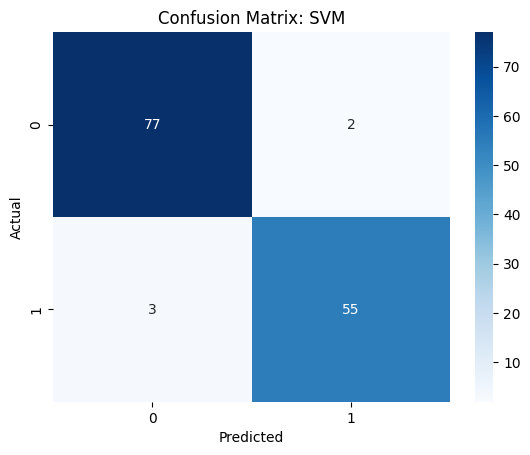

In [13]:
# Confusion matrix for the best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Performance Bar Plot (for GitHub flair)

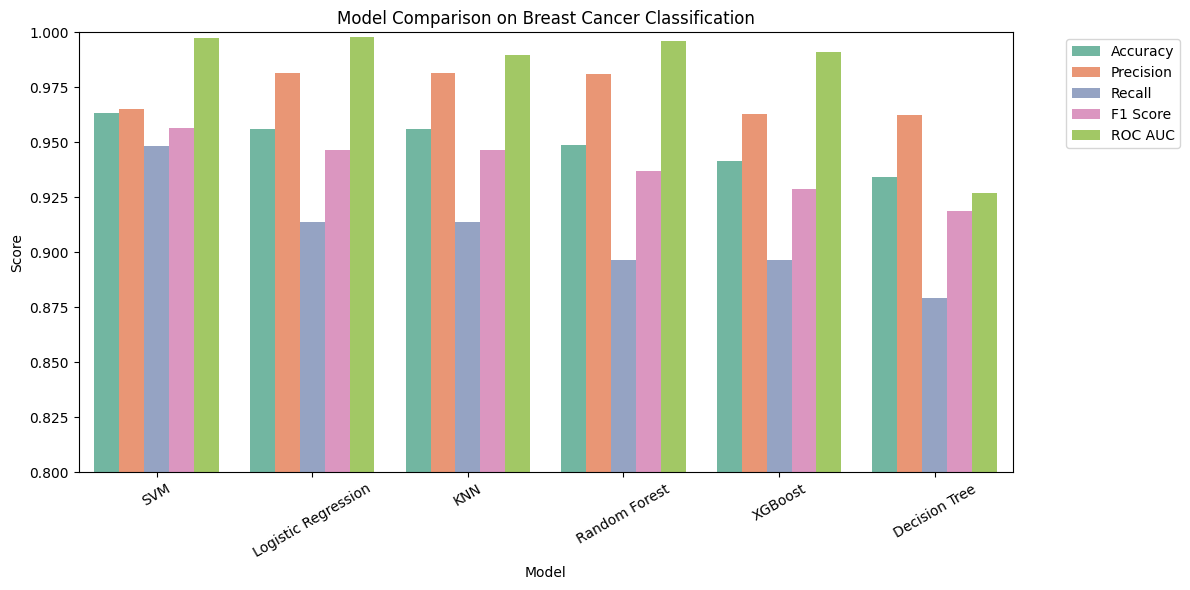

In [14]:
# Set up the bar plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

# Create a grouped bar plot
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='Set2')

plt.title('Model Comparison on Breast Cancer Classification')
plt.xticks(rotation=30)
plt.ylim(0.8, 1.0)  # You can adjust based on your model scores
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
!ls

breast+cancer+wisconsin+original.zip  dataset  model_comparison.png  sample_data


## Enter the values for cell and see the prediction if it is benign or malignent.

In [16]:
print("Enter your values:")
clump=int(input("Clump Thickness: "))
cell_size=int(input("Uniformity of Cell Size: "))
cell_shape=int(input("Uniformity of Cell Shape: "))
marginal_adhesion=int(input("Marginal Adhesion: "))
epithelial_cell_size=int(input("Single Epithelial Cell Size: "))
bare_nuclei=int(input("Bare Nuclei: "))
bland_chromatin=int(input("Bland Chromatin: "))
normal_nuclei=int(input("Normal Nucleoli: "))
mit=int(input("Mitoses: "))

new_sample=[[clump,cell_size,cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mit]]
new_sample_scaled = scaler.transform(new_sample)

# Predict using best model
prediction = best_model.predict(new_sample_scaled)
proba = best_model.predict_proba(new_sample_scaled)

print("Prediction:", "Malignant" if prediction[0] == 1 else "Benign")
print("Confidence:", round(proba[0][prediction[0]] * 100, 2), "%")

Enter your values:
Clump Thickness: 8
Uniformity of Cell Size: 6
Uniformity of Cell Shape: 8
Marginal Adhesion: 5
Single Epithelial Cell Size: 4
Bare Nuclei: 5
Bland Chromatin: 7
Normal Nucleoli: 3
Mitoses: 2
Prediction: Malignant
Confidence: 97.63 %


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
